In [106]:
import nbsetup as nb
import ensemblepy as ep
import seaborn as sns

In [261]:
import numpy as np

class Parcel(object):
    """
    A simple object that gets passed through the nodes
    For instance a chip in a silicon factory
    """
    def __init__(self, created_at):
        self.created_at = created_at
        self.history = []
        self.record(created_at, 0)
    
    def record(self, time, worktime):
        self.history.append((time-self.created_at, worktime))


class Node(object):
    """
    A node where a parcel needs to pass through
    For instance a toolchain in a silicon factory
    or a depot in a delivery chain
    """
    def __init__(self, average, std=3):
        self.average = average
        self.std = std
        self.parcel = None
        self.finished = 0

    def is_finished(self, time):
        return self.parcel is not None and time >= self.finished

    def recieve(self, time, parcel):
        worktime = int(np.random.normal(self.average, self.std))
        self.finished = time+worktime
        parcel.record(time, worktime)
        self.parcel = parcel
        return worktime


class System(object):
    """
    The network of nodes
    """
    def __init__(self, setup, std=3):
        self.results = []
        self.worktimes = []
        self.parcels = []
        self.layers = {}
        for layer, row in enumerate(setup):
            nodes = []
            for average in row:
                nodes.append(Node(average, std))
            self.layers[layer] = nodes

        self.index = list(self.layers.keys())
        self.index.reverse()
        self.time = 0

    def empty_nodes(self, layer):
        empty = []
        for node in self.layers[layer]:
            if node.parcel is None:
                empty.append(node)
        return empty

    def last_layer(self):
        for node in self.layers[self.index[0]]:
            if node.is_finished(self.time):
                self.results.append(self.time-node.parcel.created_at)
                node.parcel.record(self.time, None)
                self.parcels.append(node.parcel)
                node.parcel = None

    def previous_layers(self):
        for layer in self.index[1:]:
            nodes = self.layers[layer]
            np.random.shuffle(nodes)
            for node in nodes:
                if node.is_finished(self.time):
                    empty_node_from_next_layer = self.empty_nodes(layer+1)
                    if empty_node_from_next_layer:
                        worktime = empty_node_from_next_layer[0].recieve(self.time, node.parcel)
                        node.parcel = None
                        self.worktimes.append(worktime)

    def first_layer(self):
        for node in self.layers[0]:
            if node.parcel is None:
                node.parcel = Parcel(self.time)

    def step(self):
        self.time += 1
        self.last_layer()
        self.previous_layers()
        self.first_layer()
    
    def simulate(self, steps):
        [self.step() for _ in range(steps)]
        return self.results[int(len(self.results)*0.1):]

    

In [340]:
def multisim(settings, ensembles=5, steps=10000, std=5):
    results, systems = [], []
    for _ in range(ensembles):
        sys = System(settings, std=std)
        results.append(sys.simulate(steps))
        systems.append(sys)
    d = ep.Discrete(results, ep.binobs(results, 20))
    print(d.incoherence)
    #ep.plot_discrete(d)
    sns.histplot(results)
    return d

0.014324741995016207


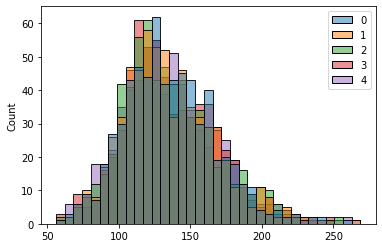

In [344]:
results = multisim([[5,3],[7,8],[50,100,80,60,80],[12,8]])

0.02097283245494119


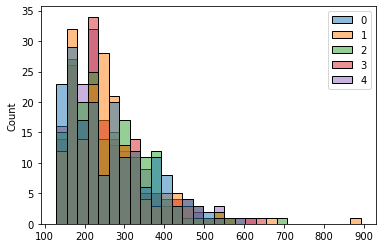

In [347]:
results = multisim([[5,3],[7,8],[50],[12,8]])

0.017115143873009844


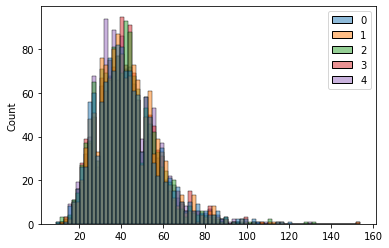

In [348]:
results = multisim([[5,3],[7,8],[5],[12,8]])